<a href="https://colab.research.google.com/github/KumarGaurav20/Spam-Emails/blob/main/Spam_Filteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FILTERING AND VISUALIZING EMAILS** 

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [71]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt


CONSTANTS


In [60]:
FILE_PATH= '/content/gdrive/MyDrive/COLAB DATA/SpamData/01_Processing/practice_email.txt'
DATA_JSON_FILE= '/content/gdrive/MyDrive/COLAB DATA/email-text-data.json'

SPAM_1_PATH= '/content/gdrive/MyDrive/COLAB DATA/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH= '/content/gdrive/MyDrive/COLAB DATA/SpamData/01_Processing/spam_assassin_corpus/spam_2'
HAM_1_PATH= '/content/gdrive/MyDrive/COLAB DATA/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
HAM_11_PATH= 'D:\Machine Learning\6. Pre-Process Text Data for a Naive Bayes Classifier to Filter Spam Emails Part 1\SpamData\01_Processing\spam_assassin_corpus\easy_ham_1'
HAM_2_PATH= '/content/gdrive/MyDrive/COLAB DATA/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT= 1
HAM_CAT= 0



Function for Email Body Generation


In [14]:
# Fuction to generate the email body
def email_body_generator(path):
  for root, dirnames, filenames in walk(path): #walk iterates and returns the three tuple pf files in a  given folder
    for file_name in filenames:
      
      filepath= join(root, file_name)
      stream= open(filepath, encoding='latin_1')
      #checking if it's email body or not
      is_body= False 
      #for reading the lines into a list
      lines=[] 
      for line in stream:
        if is_body:
          lines.append(line)
      #check for new line(as header is separated with body by a new line )
        elif line=="\n":
          is_body=True
          
      stream.close()
      # converting the list into a string
      email_body='\n'.join(lines)
      #yield is a special return type that remembers previous output
      yield file_name, email_body 
      

Function for generating dataframe of email_body


In [15]:
# classification is the category(group no) that we'll provide
def df_from_email_body(path, classification):
  rows=[]
  row_names=[]

  for file_name, email_body in email_body_generator(path):
    rows.append({'Message': email_body, 'Category': classification})
    row_names.append(file_name)

  return pd.DataFrame(rows, index=row_names)


Generating Dataframe of Spam & Normal Emails

In [47]:
spam_emails = df_from_email_body(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_email_body(SPAM_2_PATH, SPAM_CAT))

ham_emails = df_from_email_body(HAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_email_body(HAM_2_PATH, HAM_CAT))


In [48]:
data_combined= pd.concat([spam_emails, ham_emails])

In [49]:
data_combined.head()

,Message,Category
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00292.dbf78a2aaa230d288eb80ab843804252,"REGISTER .COM, .BIZ, AND .INFO DOMAINS FOR ONL...",1
00367.9688cdee9dfe720c297672c8f60d998f,++++++++++++++++++++++++++++++++++++++++++++++...,1
00282.0e230e05877f40a522bfb93aa3e314f3,<html>\n\n<head>\n\n</head>\n\n<center>\n\n<h1...,1
00448.a6ac96e93ef03ec1a638c577c6940f5e,<html>\n\n\n\n<head>\n\n<title>Classic Wines</...,1


In [50]:
data_combined.tail()

,Message,Category
01037.bfe999fe03b3c6b5b7cc2360c793e5a0,"On Thu, 2002-08-15 at 17:53, Jesse wrote:\n\n>...",0
01057.b2810601523d3bb9051088959078e309,"Hello Gary,\n\n\n\n\n\nUh, plague is not actio...",0
01261.8335ae817bc240842df41dd7c3de2420,\n\n\n\n> -----Original Message-----\n\n> From...,0
01308.27ef6351cd2bcfef79df9ec5b563afae,"On Tue, Jul 23, 2002 at 03:43:24PM -0400, rODb...",0
00910.4b1bddb9bfc1cea936f0f8cae0cd097d,"On Friday, July 26, 2002, at 12:19 PM, James R...",0


Checking for null columns

In [51]:
data_combined.isnull().sum()

Message     0
Category    0
dtype: int64

Checking for empty data

In [52]:
(data_combined.Message.str.len() == 0).sum()


3

Locating And Removing Empty Strings

In [53]:
# Getting index
data_combined[data_combined.Message.str.len() == 0].index



Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [54]:
# Removing the empty strings
data_combined.drop(['cmds'], inplace=True)

In [57]:
document_ids= range(0, len(data_combined.index))
data_combined['DOC_ID']= document_ids
data_combined['FILENAMES']= data_combined.index
data_combined.set_index('DOC_ID', inplace=True)

Saving Data

In [61]:
data_combined.to_json(DATA_JSON_FILE)

## DATA VISUALIZATION

PIE CHART

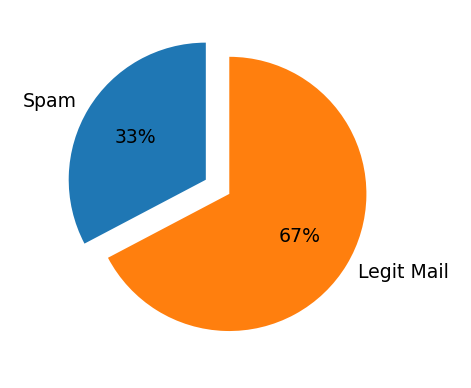

In [82]:
#  Storing amounts
amt_ham, amt_spam= data_combined.Category.value_counts()
category_names = ['Spam', 'Legit Mail']
sizes = [amt_spam, amt_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%',  explode = [0.2, 0])
plt.show()

DONUT

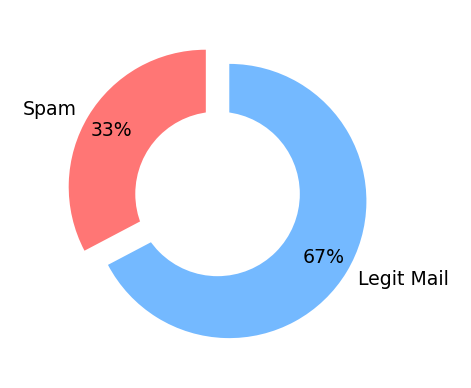

In [88]:


plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=[0.1,0.1])

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()